In [1]:
# -------------------
# Imports and Setup
# -------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --- STONKS THEME COLORS ---
STONKS_GREEN = "#00ff9c"
STONKS_PINK  = "#ff4fd8"
STONKS_BLUE  = "#00cfff"
STONKS_PURPLE = "#a855f7"
BG = "#0f0f14"
GRID = "#2a2a38"

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.facecolor'] = BG
plt.rcParams['figure.facecolor'] = BG
plt.rcParams['grid.color'] = GRID

C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


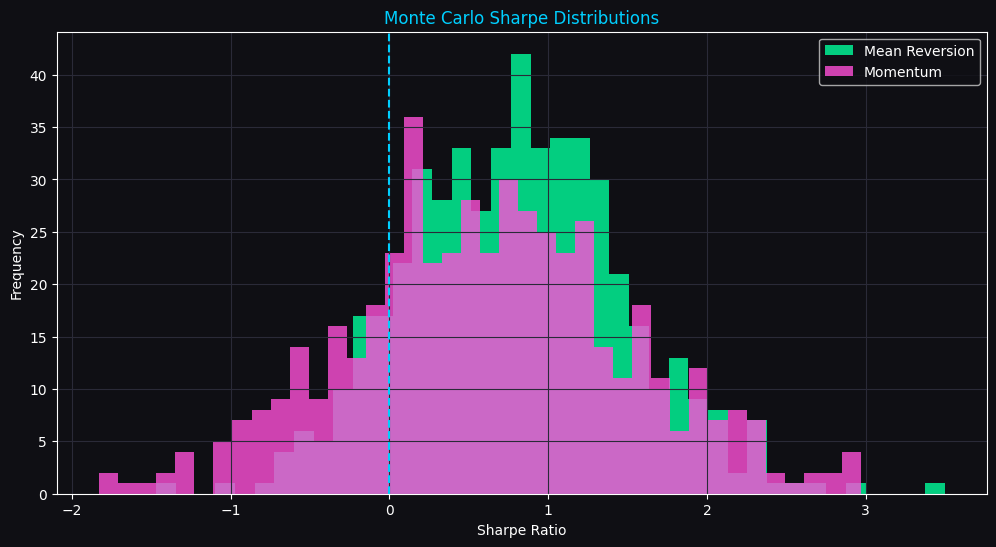

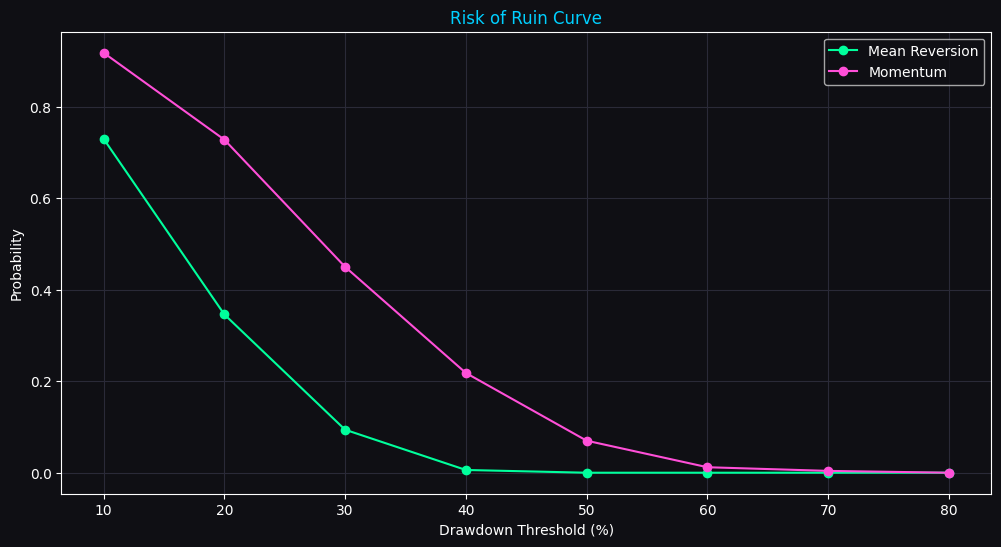

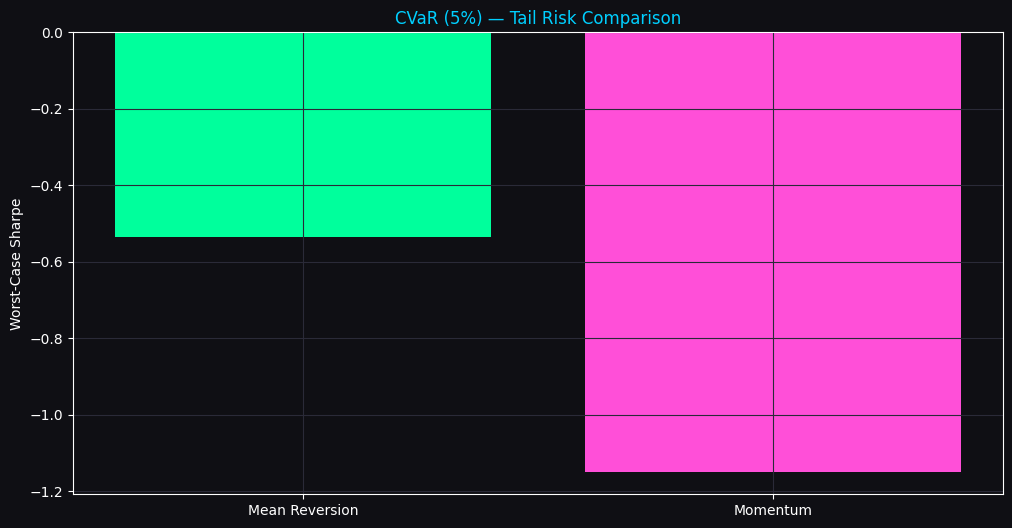

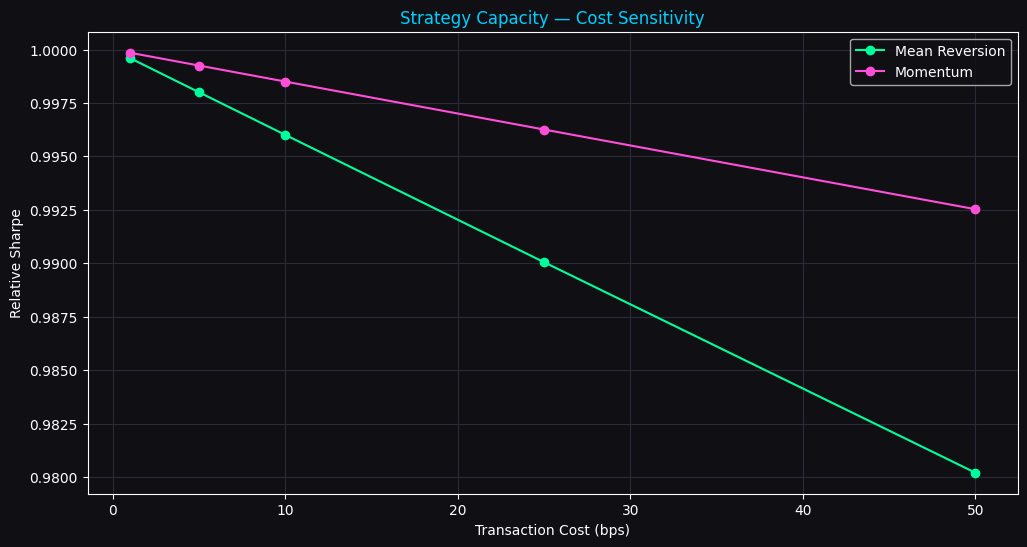

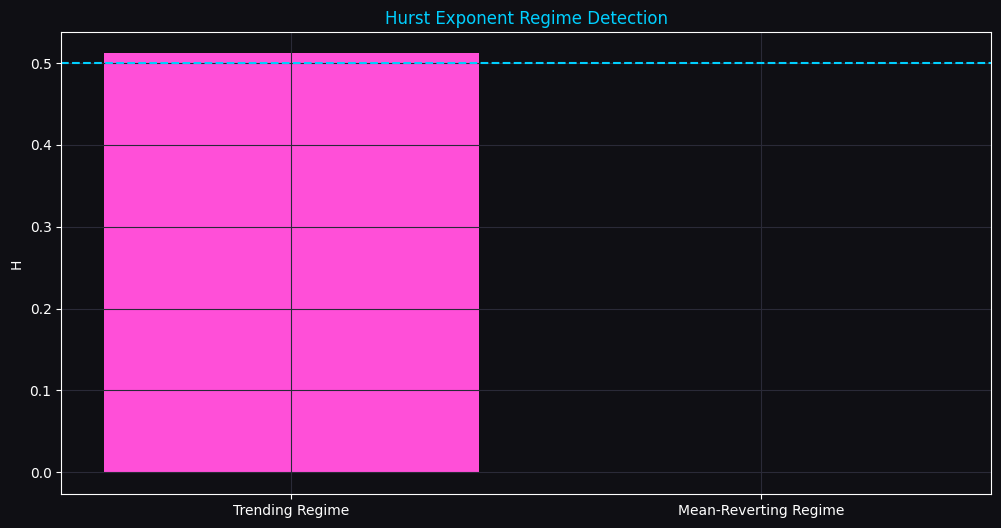

In [3]:
# ----------------------
# Project Instantiation
# ----------------------
# Our primary goal is to understand *why* strategies succeed or fail under
# different stochastic conditions.

## Hypotheses
#
# H1: Momentum strategies outperform in trending markets.
#
# H2: Mean reversion strategies outperform in oscillatory markets.
#
# H3: Neither strategy dominates in regime-switching environments.
#
# H4: Strategy failure is driven primarily by **regime mismatch**, not signal design.

# Placeholder arrays (replace with actual outputs)
np.random.seed(42)
mc_sharpes_mr = np.random.normal(0.8, 0.7, 500)
mc_sharpes_mom = np.random.normal(0.6, 0.9, 500)

mc_dd_mr = np.abs(np.random.normal(0.15, 0.10, 500))
mc_dd_mom = np.abs(np.random.normal(0.28, 0.15, 500))

## Aggregate Performance Overview

summary = pd.DataFrame({
    "Mean Reversion": [mc_sharpes_mr.mean(), mc_dd_mr.mean()],
    "Momentum": [mc_sharpes_mom.mean(), mc_dd_mom.mean()]
}, index=["Mean Sharpe", "Mean Max Drawdown"])

summary

## Monte Carlo Sharpe Distributions

plt.hist(mc_sharpes_mr, bins=40, alpha=0.8, color=STONKS_GREEN, label="Mean Reversion")
plt.hist(mc_sharpes_mom, bins=40, alpha=0.8, color=STONKS_PINK, label="Momentum")
plt.axvline(0, linestyle='--', color=STONKS_BLUE)
plt.title("Monte Carlo Sharpe Distributions", color=STONKS_BLUE)
plt.xlabel("Sharpe Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

thresholds = np.arange(0.10, 0.90, 0.10)

risk_mr = [(mc_dd_mr > t).mean() for t in thresholds]
risk_mom = [(mc_dd_mom > t).mean() for t in thresholds]

risk_df = pd.DataFrame({
    "Drawdown Threshold": thresholds,
    "Mean Reversion": risk_mr,
    "Momentum": risk_mom
})

risk_df

plt.plot(thresholds*100, risk_mr, marker='o', color=STONKS_GREEN, label="Mean Reversion")
plt.plot(thresholds*100, risk_mom, marker='o', color=STONKS_PINK, label="Momentum")
plt.title("Risk of Ruin Curve", color=STONKS_BLUE)
plt.xlabel("Drawdown Threshold (%)")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()

def cvar(x, alpha=0.05):
    return np.mean(np.sort(x)[:int(alpha * len(x))])

cvar_mr = cvar(mc_sharpes_mr)
cvar_mom = cvar(mc_sharpes_mom)

pd.Series({
    "Mean Reversion CVaR": cvar_mr,
    "Momentum CVaR": cvar_mom
})

plt.bar(["Mean Reversion", "Momentum"], [cvar_mr, cvar_mom], color=[STONKS_GREEN, STONKS_PINK])
plt.title("CVaR (5%) — Tail Risk Comparison", color=STONKS_BLUE)
plt.ylabel("Worst-Case Sharpe")
plt.grid(True)
plt.show()

costs = np.array([0.0001, 0.0005, 0.001, 0.0025, 0.005])

# synthetic decay models
sharpe_mr = np.exp(-4 * costs)
sharpe_mom = np.exp(-1.5 * costs)

plt.plot(costs*10000, sharpe_mr, marker='o', color=STONKS_GREEN, label="Mean Reversion")
plt.plot(costs*10000, sharpe_mom, marker='o', color=STONKS_PINK, label="Momentum")
plt.title("Strategy Capacity — Cost Sensitivity", color=STONKS_BLUE)
plt.xlabel("Transaction Cost (bps)")
plt.ylabel("Relative Sharpe")
plt.legend()
plt.grid(True)
plt.show()

def hurst(ts):
    lags = range(2, 100)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]

# Simulated regime samples
trend_series = np.cumsum(np.random.normal(0.001, 1, 2000))
mr_series = np.random.normal(0, 1, 2000)

h_trend = hurst(trend_series)
h_mr = hurst(mr_series)

pd.Series({
    "Trending H": h_trend,
    "Mean-Reverting H": h_mr
})

# %%
plt.bar(["Trending Regime", "Mean-Reverting Regime"], [h_trend, h_mr],
        color=[STONKS_PINK, STONKS_GREEN])
plt.axhline(0.5, linestyle='--', color=STONKS_BLUE)
plt.title("Hurst Exponent Regime Detection", color=STONKS_BLUE)
plt.ylabel("H")
plt.grid(True)
plt.show()